In [9]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%run ./common_init.ipynb

In [11]:
%run ./learning_init.ipynb

In [12]:
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
import pathlib
import pickle

In [13]:
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [51]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, make_scorer, log_loss, roc_auc_score, balanced_accuracy_score, precision_score, classification_report, roc_curve, auc
from glmnet import LogitNet

In [7]:
# Where to save the figures

CHAPTER_ID = "gradient_boosting"
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output/'eda')

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

In [8]:
with open(pathlib.Path(Config.get("df_store"), "X_train.pd.pkl"), "rb") as f:
    kdd98_learn_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_train.pd.pkl"), "rb") as f:
    kdd98_learn_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test.pd.pkl"), "rb") as f:
    kdd98_test_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_test.pd.pkl"), "rb") as f:
    kdd98_test_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_train_all_relevant.pd.pkl"), "rb") as f:
    kdd98_learn_feat_all_relevant = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test_all_relevant.pd.pkl"), "rb") as f:
    kdd98_test_feat_all_relevant = pickle.load(f)
    
# Extracting the data and resetting target to [-1, 1]
X_train = kdd98_learn_feat.values
X_train_all_relevant = kdd98_learn_feat_all_relevant.values
y_train = kdd98_learn_targets.loc[:,"TARGET_B"].astype("int64").values
X_test = kdd98_test_feat.values
X_test_all_relevant = kdd98_test_feat_all_relevant.values
y_test = kdd98_test_targets.loc[:,"TARGET_B"].astype("int64").values

In [22]:
class_weight = len(y_train[y_train == 0])/sum(y_train)

In [53]:
ovs = RandomOverSampler(sampling_strategy="minority", random_state=Config.get("random_seed"))
X_resampled, y_resampled = ovs.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 72455), (1, 72455)]


In [54]:
ptrans = PowerTransformer()

X_rescaled = ptrans.fit_transform(X_resampled)
X_test_rescaled = ptrans.transform(X_test)

/data/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


# GLM Net

In [55]:
logitnet = LogitNet(alpha=0.2,
                    n_splits=5,
                    random_state=Config.get("random_seed"))

In [56]:
logitnet.fit(X_rescaled, y_resampled)

LogitNet(alpha=0.2, cut_point=1.0, fit_intercept=True, lambda_path=None,
     lower_limits=-inf, max_features=None, max_iter=100000,
     min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=5,
     random_state=42, scoring=None, standardize=True, tol=1e-07,
     upper_limits=inf, verbose=False)

In [57]:
y_predict = logitnet.predict(X_test_rescaled)

Confusion matrix, without normalization
[[  565   404]
 [ 6066 12048]]


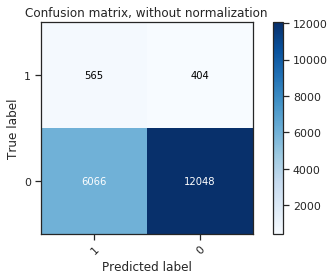

In [58]:
plot_confusion_matrix(y_test,y_predict, classes=[1,0])

In [59]:
param_grid = {"alpha": [0.,0.2,1.]}

roc = make_scorer(roc_auc_score)

logitnet = LogitNet(n_splits=5,
                    random_state=Config.get("random_seed"))

In [60]:
gs_glm_logit = GridSearchCV(
    logitnet,
    param_grid,
    scoring= make_scorer(log_loss, labels = [0,1]),
    n_jobs=-1,
    cv=5,
    refit="logloss",
    verbose=3
)

In [ ]:
gs_glm_logit.fit(X_rescaled, y_resampled)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 25.9min remaining: 38.9min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 42.4min remaining: 10.6min


In [ ]:
gs_glm_logit.best_estimator_.get_params

In [ ]:
y_predict = gs_glm_logit.best_estimator_.predict(X_test_rescaled)

In [ ]:
confusion_matrix(y_test, y_predict)

In [ ]:
plot_confusion_matrix(y_test, y_predict, classes=[0,1])

In [62]:
importances = pd.DataFrame(gs_unbalanced_xgboost_boruta.best_estimator_.feature_importances_, index=kdd98_learn_feat_all_relevant.columns.values.tolist(), columns=["importance"])

In [63]:
importances = importances.sort_values(by="importance", ascending=False)

In [64]:
factor_importance = 100/importances.iloc[0,0]
factor_importance

3664.087370662276

In [65]:
importances.importance = importances.importance.map(lambda i: i*factor_importance)

,importance
GEOCODE_02,100.000000
NUMCHLD,91.071427
ZIP_longitude,87.500001
AGE,86.706348
POBC2,83.333334
IC5,76.785715
MAGMALE,70.238095
DMA,68.849209
RFA_23F,68.452382
HHAS3,67.658729


In [73]:
most_important = importances.head(50)
most_important

,importance
GEOCODE_02,100.000000
NUMCHLD,91.071427
ZIP_longitude,87.500001
AGE,86.706348
POBC2,83.333334
IC5,76.785715
MAGMALE,70.238095
DMA,68.849209
RFA_23F,68.452382
HHAS3,67.658729


In [74]:
import seaborn as sns

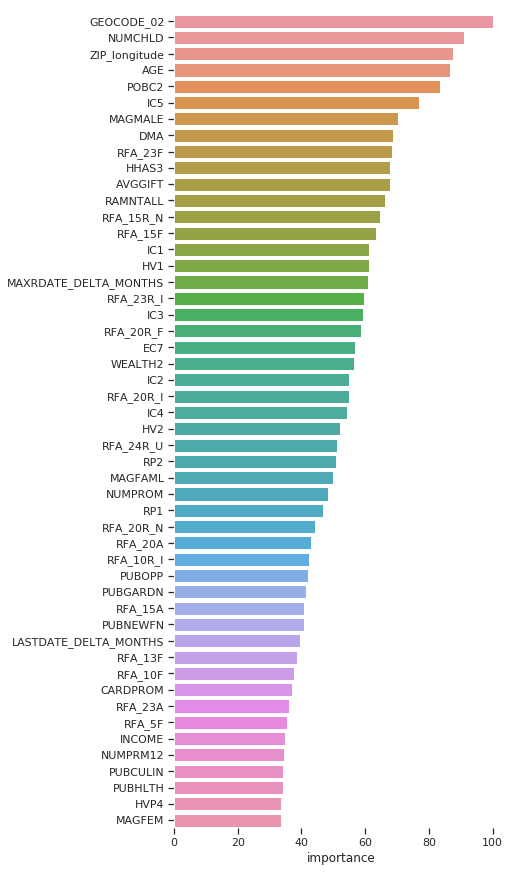

In [75]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(y=most_important.index, x=most_important.importance)
sns.despine(left=True, bottom=True)
ylabel("Relative importance")